# Smooth Grad

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

%matplotlib inline

## Helper function and constants

In [2]:
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
DIAGS = [
    "1st degree AV block (1dAVb)",
    "right bundle branch block (RBBB)",
    "left bundle branch block (LBBB)",
    "sinus bradycardia (SB)",
    "atrial fibrillation (AF)",
    "sinus tachycardia (ST)",
]

In [3]:
def plot_ecg(X):
    for c in range(12):
        plt.figure(figsize=(20, 5))
        plt.plot(X[:, c])
        plt.title(LEADS[c])
        plt.grid()

    plt.show()

## Extract data

In [4]:
import xml.etree.ElementTree as ET


def get_diagnosis(filename: str) -> str:
    root = ET.parse(filename).getroot()
    node = root[6]
    
    diagnosis = 'Diagnosis:\n'
    for i in node:
        if i.tag == "DiagnosisStatement":
            for j in i:
                if j.tag == "StmtText":
                    diagnosis += '\n' + j.text
    return diagnosis

In [5]:
import os
files = []
for folder, _, file_list in os.walk('./data'):
    if 'ipynb' in folder:
        continue
    for file in file_list:
        if file[-4:] == '.xml' and 'MUSE' in file:
            files.append(os.path.join(folder, file)[:-4])

In [6]:
ecg = []
diagnosis = []
for file in files:
    data = pd.read_csv('data/' + file.split('/')[-1] + '.csv').drop(columns=["Unnamed: 12", "Unnamed: 13", "V4R"], errors='ignore')
    diag = get_diagnosis(file + '.xml')
    ecg.append(data)
    diagnosis.append(diag)
    # print(file, '\n', diagnosis, '\n', '--------------------------', '\n')\
ecg = np.array(ecg)

In [7]:
# plot_ecg(X[0])

## Load Model

In [8]:
import tensorflow as tf
from keras.models import load_model
from keras.optimizers import Adam

model = load_model("model/model.hdf5", compile=False)
model.compile(loss="binary_crossentropy", optimizer=Adam())

2023-01-16 14:40:00.691318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 14:40:04.254022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 14:40:04.255792: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Reformat data for model

In [9]:
X = scipy.signal.resample(ecg, 4000, axis=-2)
if len(X.shape) == 2:
    X = X[None, ...]
X = np.pad(X, ((0, 0), (48, 48), (0, 0)), "constant")
X = X / 500
print(X.shape)

(15, 4096, 12)


In [10]:
Y = model.predict(X)

1/1 [==============================] - 1s 759ms/step


In [11]:
Y > 0.5

array([[False, False, False, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False,  True, False],
       [False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [17]:
Y[4]

array([1.74766228e-05, 4.41855178e-07, 1.00903735e-05, 9.81243709e-09,
       9.16220665e-01, 3.01022995e-02], dtype=float32)

## Saliency Maps

In [13]:
from skimage.transform import resize
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore

In [22]:
saliency = Saliency(model, clone=True)
def score_function(output, i):
    return output[0][i]

def visualize(X):
    f, ax = plt.subplots(nrows=6, ncols=1, figsize=(20, 36))
    for i in range(6):
        # Generate saliency map
        saliency_map = saliency(
            lambda x: score_function(x, i),
            X,
            keepdims=True,
            smooth_samples=0,
            smooth_noise=0,
            normalize_map=False
        )
        print(np.max(saliency_map))
        ax[i].set_title(DIAGS[i], fontsize=16)
        ax[i].imshow(resize(saliency_map[0], (4096, 1200)).T, cmap="jet", vmax=0.01)
        ax[i].set_yticks(ticks=[i * 100 + 50 for i in range(12)], labels=LEADS)
    plt.show()

2.320236035302514e-06
0.004230912774801254
2.2924214135855436e-06
2.6044604251040937e-09
2.012239292525919e-06
8.818456520565121e-10


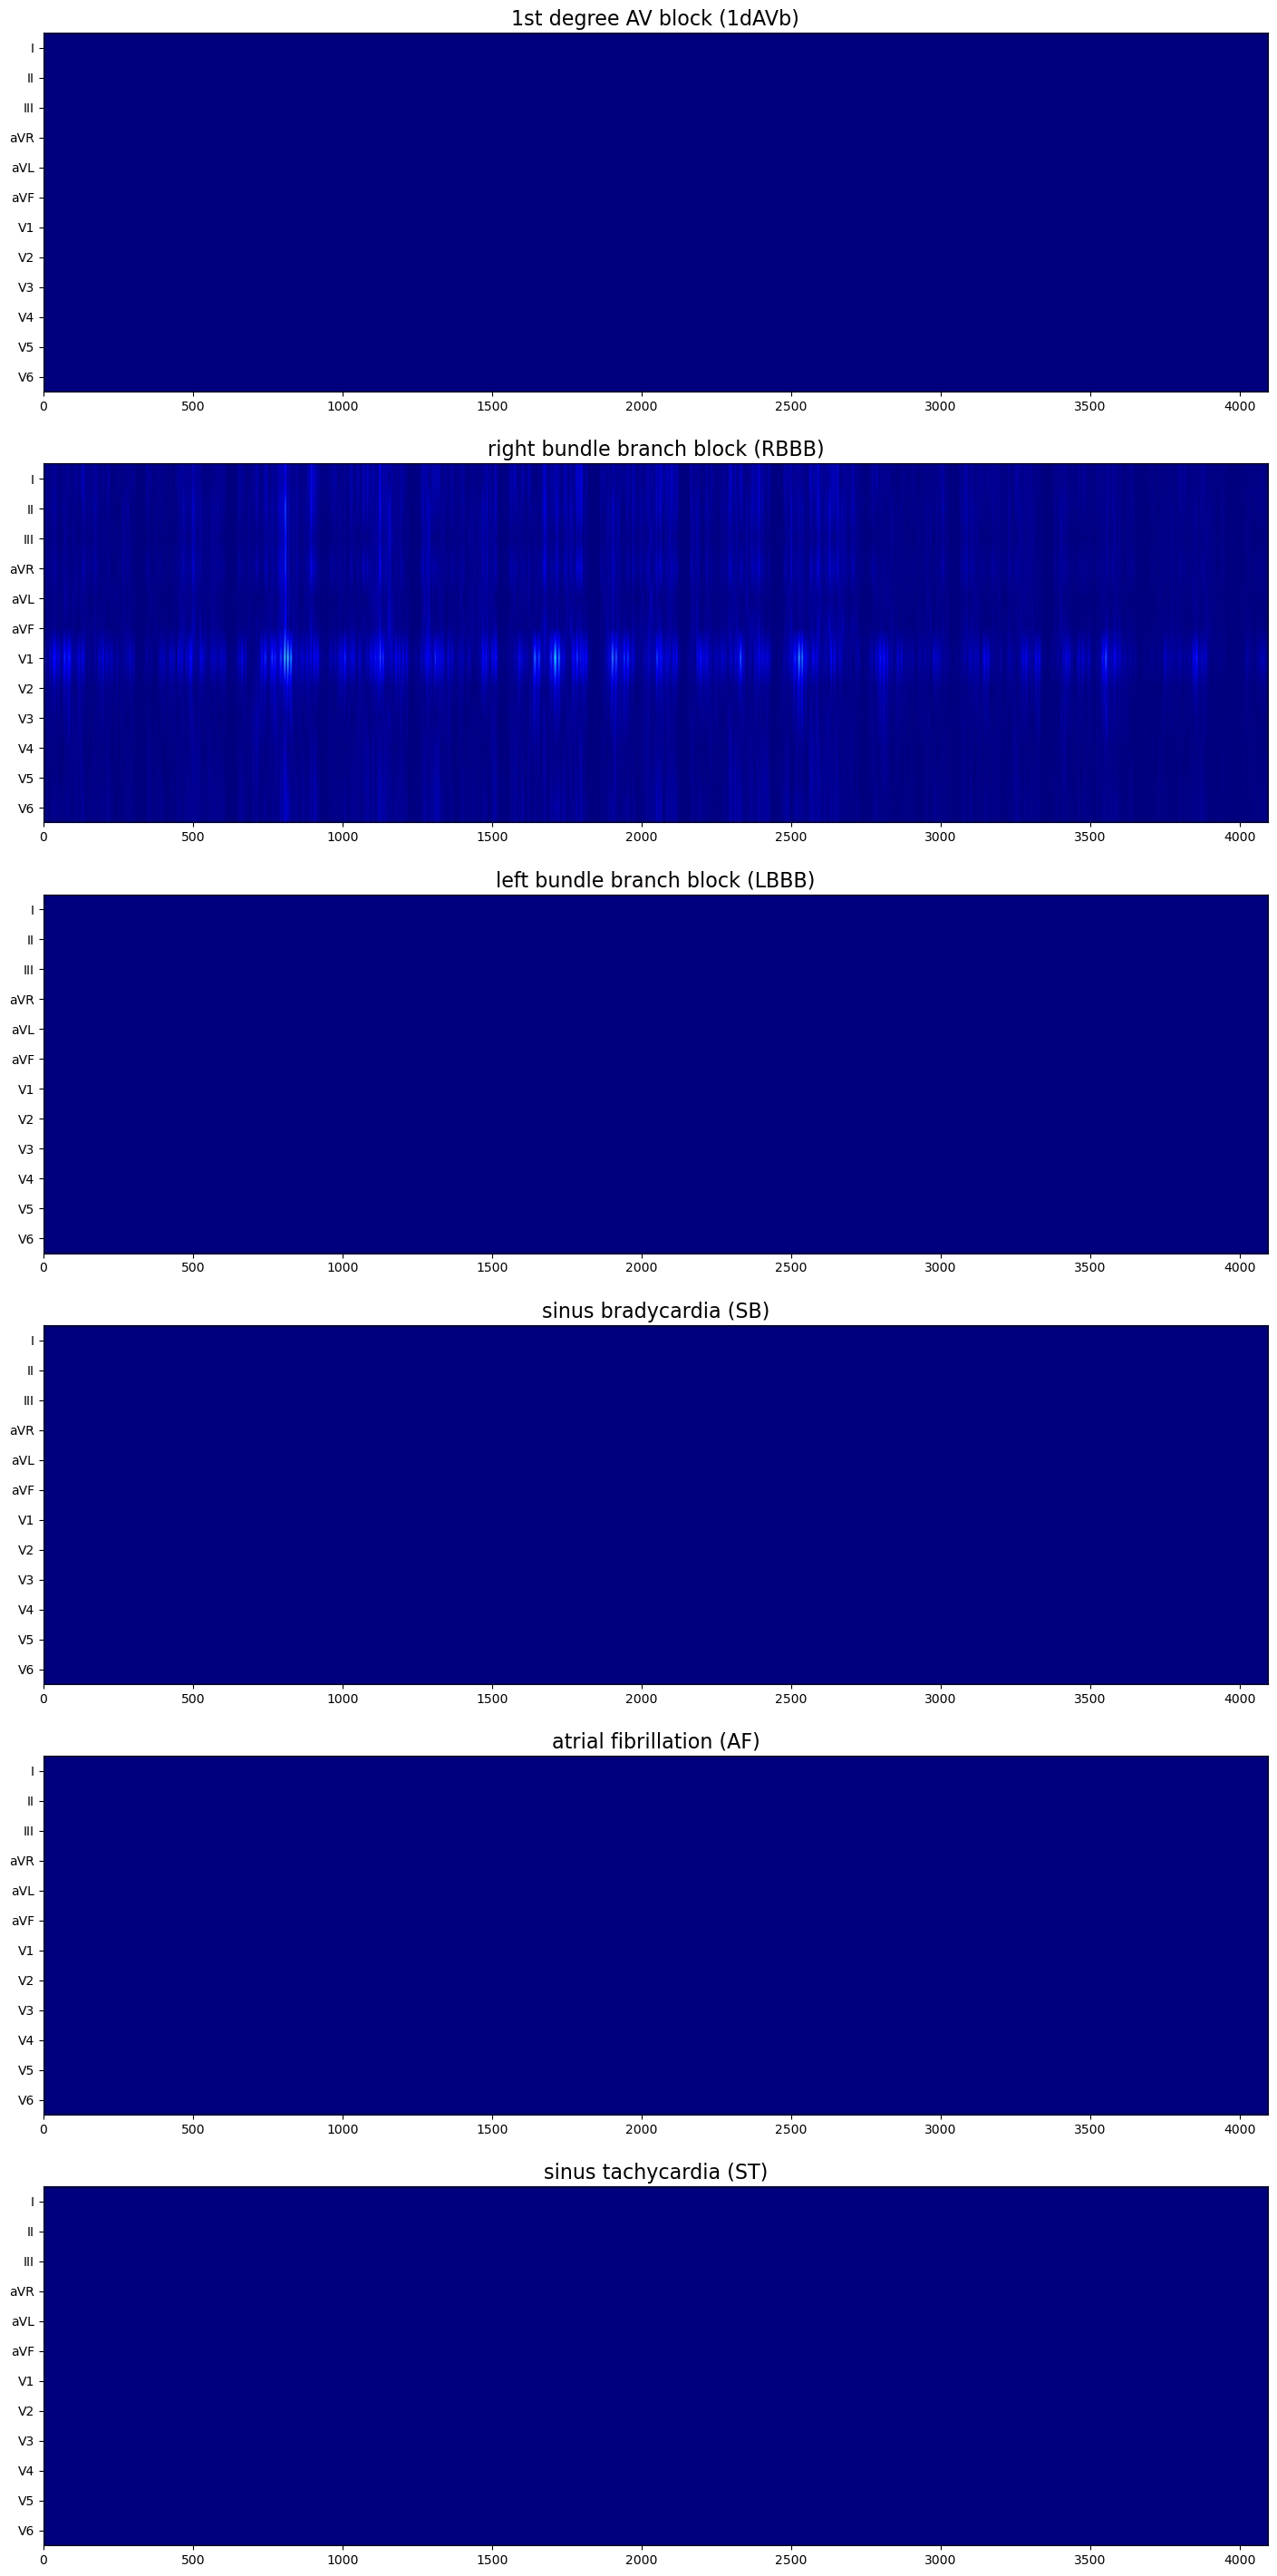

In [26]:
visualize(X[9])